# Analyze conformational entropy, as computed by CREST / GFN2 across a large molecular test set

This notebook is intended to be used in JupyterLab. YMMV

In [1]:
from __future__ import print_function

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")

from scipy import constants

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

We'll read in the combined CSV, including subset name, filename, SMILES, computational entropy, and a variety of descriptors generated by RDKit

In [2]:
df = pd.read_csv("total-entropy.csv")
# drop inf and nan (i.e. some molecules from COD don't have Gasteiger charges)
df.replace([np.inf, -np.inf], np.nan)
df.dropna(inplace=True)
print(len(df.index))
# 87949 molecules left
#  (technically we should check to make sure all the SMILES are unique!)

87949


In [3]:
# what do we have
print(df.columns)
df = df.astype({"NumAtoms": int, "NumBonds": int, "NumRotors": int, "NumMethyl": int, "NumAmine": int, "NumHydroxyl": int, "HDonors": int, "HAcceptors": int, "RingCount": int, "NumAromaticRings": int})
df.describe()

Index(['Category', 'File', 'SMILES', 'ConfEntropy', 'VibEntropy', 'RotEntropy',
       'TransEntropy', 'NumAtoms', 'NumBonds', 'ExactMolWt', 'Volume',
       'NumRotors', 'NumMethyl', 'NumAmine', 'NumHydroxyl', 'HDonors',
       'HAcceptors', 'RingCount', 'NumAromaticRings', 'MaxAbsPartialChg',
       'MinAbsPartialChg', 'MaxPartialChg', 'MinPartialChg', 'TPSA',
       'LabuteASA', 'MolMR', 'MolLogP', 'EState_VSA1', 'EState_VSA2',
       'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'HallKierAlpha', 'BertzCT',
       'BalabanJ', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'FractionCSP3',
       'Asphericity', 'Eccentricity', 'InertialShapeFactor',
       'RadiusOfGyration', 'SpherocityIndex', 'ConfUnder1', 'ConfUnder2',
       'ConfUnder3', 'ConfUnder4', 'ConfUnder5', 'ConfUnder6', 'ECFP4'],
      dtype='object')


,ConfEntropy,VibEntropy,RotEntropy,TransEntropy,NumAtoms,NumBonds,ExactMolWt,Volume,NumRotors,NumMethyl,...,Eccentricity,InertialShapeFactor,RadiusOfGyration,SpherocityIndex,ConfUnder1,ConfUnder2,ConfUnder3,ConfUnder4,ConfUnder5,ConfUnder6
count,87949.000000,87949.000000,87949.000000,87949.000000,87949.000000,87949.000000,87949.000000,87949.000000,87949.000000,87949.000000,...,87949.000000,87949.000000,87949.000000,87949.000000,87949.000000,87949.000000,87949.000000,87949.000000,87949.000000,87949.000000
mean,34.470609,408.341162,149.862348,183.312216,29.602554,32.571888,415.299401,408.558975,4.686477,2.334194,...,0.945626,0.000880,4.330246,0.175516,7.462632,19.619348,37.052951,58.713391,83.697541,111.179104
std,11.914549,136.865085,7.973041,3.887599,8.550787,9.932608,115.758279,109.989251,2.658016,2.104448,...,0.059728,0.001623,0.963279,0.136158,11.653509,31.682838,59.155031,92.113083,129.965145,170.548217
min,0.004000,29.836104,96.713160,159.339272,4.000000,3.000000,58.078250,66.904000,0.000000,0.000000,...,0.169475,0.000013,1.231888,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,27.056000,316.105384,146.201512,181.447528,24.000000,26.000000,342.081143,338.816000,3.000000,1.000000,...,0.921586,0.000316,3.666778,0.081280,2.000000,4.000000,6.000000,8.000000,10.000000,11.000000
50%,36.087000,422.918720,151.636528,184.217336,31.000000,34.000000,427.235873,422.952000,4.000000,2.000000,...,0.966219,0.000537,4.317650,0.142056,4.000000,10.000000,18.000000,27.000000,37.000000,47.000000
75%,43.026000,491.992376,154.895864,185.660816,35.000000,38.000000,480.105647,472.392000,6.000000,3.000000,...,0.988091,0.000908,4.969053,0.234509,9.000000,23.000000,45.000000,72.000000,105.000000,142.000000
max,68.287000,1659.328376,196.346752,203.702224,131.000000,192.000000,2039.240573,1410.992000,20.000000,26.000000,...,0.999999,0.162280,12.050900,0.989008,495.000000,981.000000,1403.000000,1822.000000,2410.000000,3693.000000


The goal is to understand how the computed conformational entropies change with molecular structure (e.g., number of rotatable bonds).

First off, let's try the formula from "Large-scale calculations of gas phase thermochemistry: Enthalpy of formation, standard entropy, and heat capacity"
*J. Chem. Phys.* 145 art. 114305 (2016); https://doi.org/10.1063/1.4962627

$$ S_{conf} = R \times (\textrm{Number of Rotors})$$

In [4]:
import sklearn
from sklearn.metrics import mean_absolute_error

pred = constants.R * df['NumRotors']
print(mean_absolute_error(df['ConfEntropy'], pred))

15.954857698827727


Okay, but not great: ~16.0 J/mol•K - that's ~1.1 kcal/mol at 300K

What does the data look like - comparing entropy against the # of rotatable bonds?

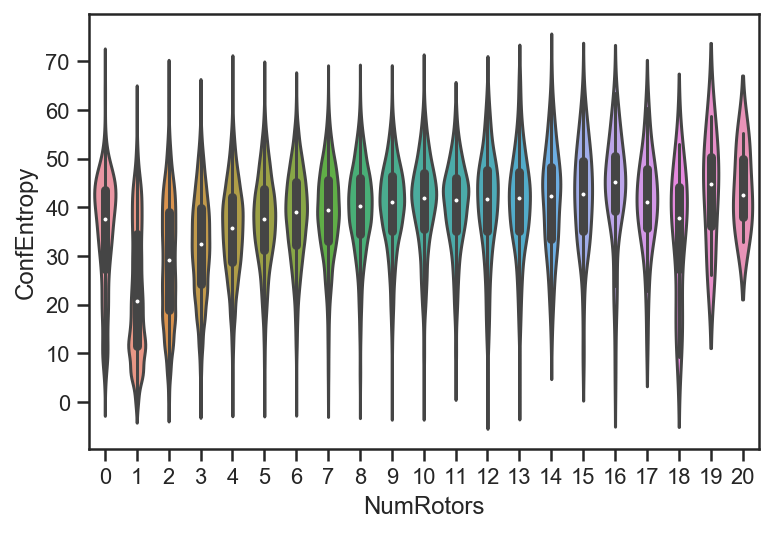

In [5]:
sns.violinplot(x="NumRotors", y="ConfEntropy", data=df)

Clearly entropy isn't very linear with the number of rotatable bonds - but perhaps we can get better error with a full linear model

In [6]:
lm = ols('ConfEntropy~NumRotors', data=df).fit()
print(lm.summary())
print('mean absolute error:', mean_absolute_error(df['ConfEntropy'], lm.fittedvalues))

                            OLS Regression Results                            
Dep. Variable:            ConfEntropy   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                 1.508e+04
Date:                Sat, 12 Oct 2019   Prob (F-statistic):               0.00
Time:                        22:53:36   Log-Likelihood:            -3.3575e+05
No. Observations:               87949   AIC:                         6.715e+05
Df Residuals:                   87947   BIC:                         6.715e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     26.4339      0.075    351.322      0.0

Nice, we've dropped the MAE from 16.0 J/mol•K to 8.9 J/mol•K - although clearly this isn't a great model either

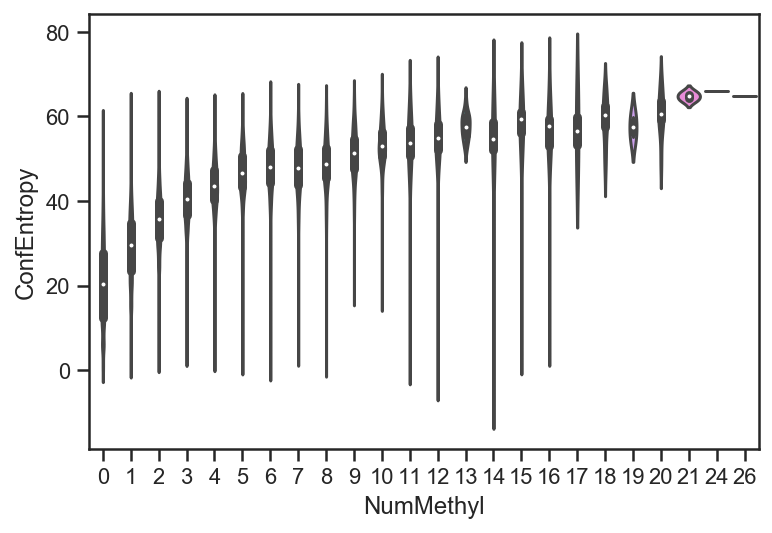

In [7]:
sns.violinplot(x="NumMethyl", y="ConfEntropy", data=df)

The # of methyl groups seems to have a much better prediction of conformational entropy

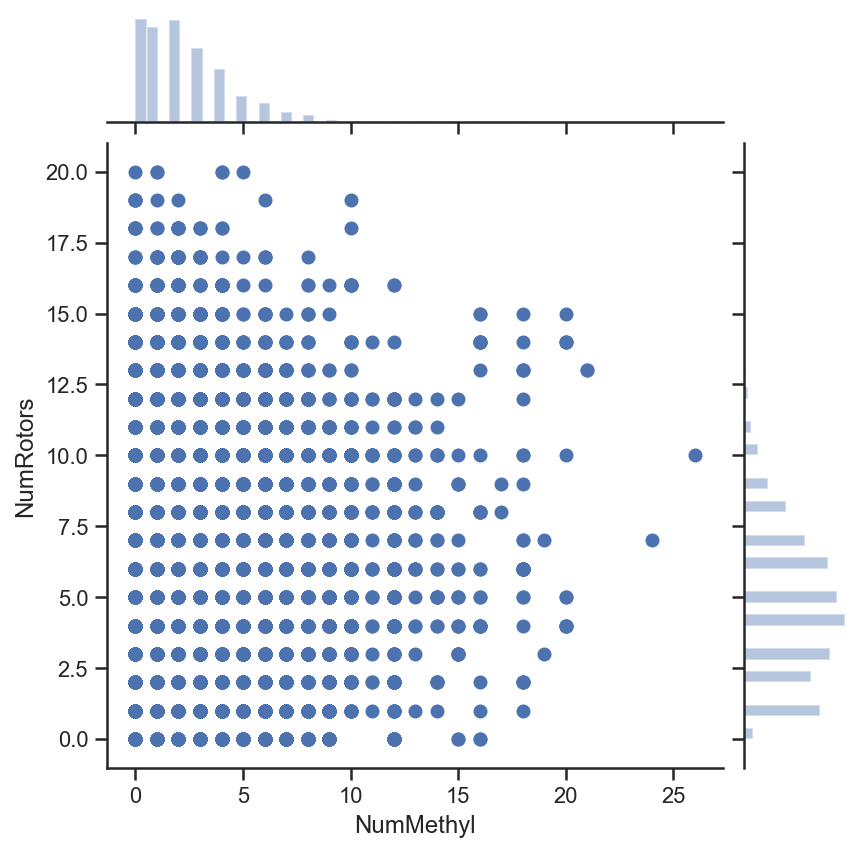

In [8]:
sns.jointplot(x="NumMethyl", y="NumRotors", data=df)

In [9]:
lm = ols('ConfEntropy~NumRotors+NumMethyl', df).fit()
print(lm.summary())
print('mean absolute error:', mean_absolute_error(df['ConfEntropy'], lm.fittedvalues))

                            OLS Regression Results                            
Dep. Variable:            ConfEntropy   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                 6.206e+04
Date:                Sat, 12 Oct 2019   Prob (F-statistic):               0.00
Time:                        22:53:39   Log-Likelihood:            -3.0401e+05
No. Observations:               87949   AIC:                         6.080e+05
Df Residuals:                   87946   BIC:                         6.080e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     19.6445      0.057    344.819      0.0

In [10]:
lm = ols('ConfEntropy~np.log(NumRotors+1)+np.log(NumMethyl+1)', df).fit()
print(lm.summary())
print('mean absolute error:', mean_absolute_error(df['ConfEntropy'], lm.fittedvalues))

                            OLS Regression Results                            
Dep. Variable:            ConfEntropy   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                 8.917e+04
Date:                Sat, 12 Oct 2019   Prob (F-statistic):               0.00
Time:                        22:53:39   Log-Likelihood:            -2.9399e+05
No. Observations:               87949   AIC:                         5.880e+05
Df Residuals:                   87946   BIC:                         5.880e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                10.88

Okay, so this new model drops the MAE down to 5.3 J/mol•K which is almost a third of the initial model
What other factors are relevant? We have to tune the formula, because some columns (descriptors) cause errors in statsmodel - likely the values have errors - but none of these are expected to be important based on chemistry intutiton anyway. 

Once we have the (large) formula, we can use LASSO or similar regularization procedures to remove factors. We'll try a range of different penalities to find one with the lowest mean absolute error.

In [11]:
formula = 'ConfEntropy~np.log(NumRotors+1)+np.log(NumMethyl+1)+' + '+'.join(df.columns[7:11]) + '+' + '+'.join(df.columns[13:19]) + '+' + '+'.join(df.columns[23:27]) + '+' + '+'.join(df.columns[32:-7])
print(formula)

ConfEntropy~np.log(NumRotors+1)+np.log(NumMethyl+1)+NumAtoms+NumBonds+ExactMolWt+Volume+NumAmine+NumHydroxyl+HDonors+HAcceptors+RingCount+NumAromaticRings+TPSA+LabuteASA+MolMR+MolLogP+HallKierAlpha+BertzCT+BalabanJ+Ipc+Kappa1+Kappa2+Kappa3+FractionCSP3+Asphericity+Eccentricity+InertialShapeFactor+RadiusOfGyration+SpherocityIndex


In [12]:
max_mae = 10.0
best_alpha = 0
for a in range(100):
    lm = ols(formula, df).fit_regularized(alpha=float(a)/100.0)
    mae = mean_absolute_error(df['ConfEntropy'], lm.fittedvalues)
    if mae < max_mae:
        best_alpha = float(a)/100.0
        max_mae = mae
        print('best so far', best_alpha, max_mae)

lm = ols(formula,df).fit_regularized(alpha=best_alpha)
print(lm.params)

best so far 0.0 5.131692565677152
best so far 0.01 5.127466048007134
Intercept                28.169306
np.log(NumRotors + 1)     5.077574
np.log(NumMethyl + 1)    12.990667
NumAtoms                 -0.367846
NumBonds                 -0.005234
ExactMolWt               -0.004459
Volume                    0.002214
NumAmine                  1.034807
NumHydroxyl               0.757179
HDonors                  -1.186042
HAcceptors                0.042569
RingCount                -0.323319
NumAromaticRings          0.340795
TPSA                      0.002367
LabuteASA                 0.005691
MolMR                    -0.002339
MolLogP                   0.475906
HallKierAlpha            -0.909259
BertzCT                  -0.001427
BalabanJ                 -3.589477
Ipc                       0.000000
Kappa1                    0.278269
Kappa2                   -0.129354
Kappa3                    0.399562
FractionCSP3              2.452198
Asphericity              -4.889715
Eccentricity         

Clearly many of these factors are removed by LASSO. We'll create a smaller subset of factors to compare with our initial model

In [13]:
lm = ols('ConfEntropy~np.log(NumRotors+1)+np.log(NumMethyl+1)+HDonors+HAcceptors+RingCount+MolLogP', df).fit()
print(mean_absolute_error(df['ConfEntropy'], lm.fittedvalues))
print(lm.summary())

5.126722987463097
                            OLS Regression Results                            
Dep. Variable:            ConfEntropy   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                 3.255e+04
Date:                Sat, 12 Oct 2019   Prob (F-statistic):               0.00
Time:                        22:58:06   Log-Likelihood:            -2.9128e+05
No. Observations:               87949   AIC:                         5.826e+05
Df Residuals:                   87942   BIC:                         5.826e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept   

These new factors add some minor corrections, improving the mean absolute error from ~5.3 J/mol•K to ~5.1 J/mol•K. More importantly, the new model suggests that hydrogen-bonding groups change the entropy (not surprising, since intramolecular hydrogen bonds would decrease the flexibility), and a molecules with more rings tend to yield lower conformational entropy.

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, RegressorMixin

class SMFormulaWrapper(BaseEstimator, RegressorMixin):
    """ A sklearn-style wrapper for formula-based statsmodels regressors """
    def __init__(self, model_class, formula):
        self.model_class = model_class
        self.formula = formula
    def fit(self, X, y=None):
        self.model_ = self.model_class(self.formula, data=X)
        self.results_ = self.model_.fit()
    def predict(self, X):
        return self.results_.predict(X)

In [15]:
initial_score = cross_val_score(SMFormulaWrapper(ols, 'ConfEntropy~np.log(NumRotors+1)+np.log(NumMethyl+1)'), df, df.ConfEntropy, cv=5)
print(initial_score.mean(), "+/-", initial_score.std())

0.6185911796123799 +/- 0.049296752487665275


In [16]:
new_score = cross_val_score(SMFormulaWrapper(ols, 'ConfEntropy~np.log(NumRotors+1)+np.log(NumMethyl+1)+HDonors+HAcceptors+RingCount+MolLogP'), df, df.ConfEntropy, cv=5)
print(new_score.mean(), "+/-", new_score.std())

0.6428671553442691 +/- 0.041521163111492086


In [17]:
max_mae = 10.0
best_alpha = 0
for a in range(150):
    alpha = float(a)/100.0
    formula = 'ConfEntropy~np.log(NumRotors+{})+np.log(NumMethyl+{})'.format(alpha, alpha)
    lm = ols(formula, df).fit()
    mae = mean_absolute_error(df['ConfEntropy'], lm.fittedvalues)
    if mae < max_mae:
        best_alpha = alpha
        max_mae = mae
        print('best so far', best_alpha, max_mae)

/usr/local/anaconda/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


MissingDataError: exog contains inf or nans